In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print ('done')

done


In [ ]:
# Training Data

train = pd.read_csv('train.csv')
print('Training data shape: ', train.shape)
train.head()

Training data shape:  (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The training data has 891 observations and 12 features (variables) including the TARGET (the label we want to predict).In this case we want to predict whether a passenger on Titanic survived or not.

In [ ]:
# Testing data features
test = pd.read_csv('test.csv')
print('Testing data shape: ', test.shape)
test.head()

Testing data shape:  (418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
#EDA

train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

<Axes: xlabel='Survived', ylabel='count'>

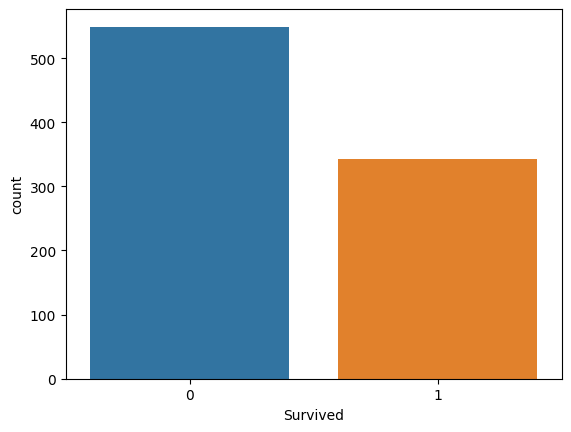

In [ ]:
sns.countplot(x = 'Survived',data = train)

Thus, around 549 people perished while 342 survived.

<Axes: xlabel='Survived', ylabel='count'>

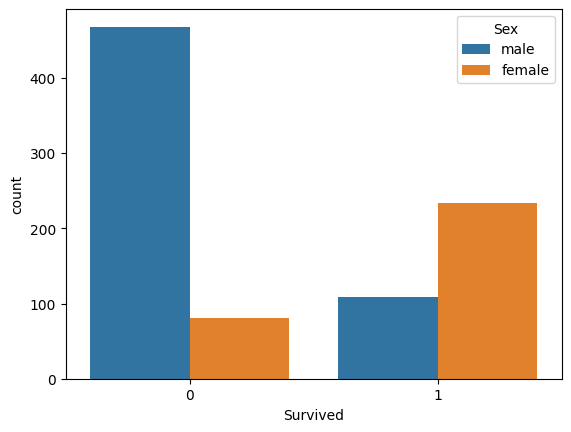

In [ ]:
sns.countplot(x = 'Survived',hue = 'Sex',data = train)

We can see that females survived in much higher proportions than males did. Now, Let’s see how many people survived divided by class.

<Axes: xlabel='Survived', ylabel='count'>

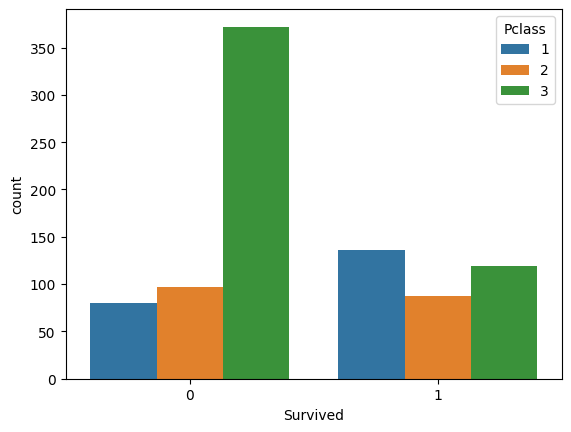

In [ ]:
sns.countplot(x = 'Survived',hue = 'Pclass',data = train)

Distribution of survival rate class wise

<Axes: xlabel='Pclass', ylabel='Age'>

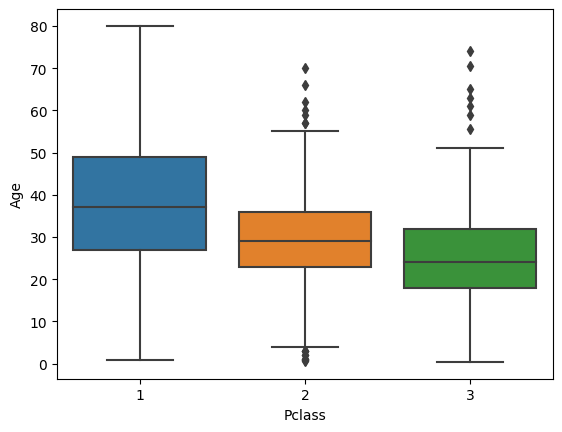

In [ ]:
sns.boxplot(x='Pclass',y='Age',data=train)

Examining Missing Values
Next we can look at the number and percentage of missing values in each column.

In [ ]:
print("Null in Training set")
print("---------------------")
print(train.isnull().sum())
print("---------------------")
print("Null in Testing set")
print("---------------------")
print(test.isnull().sum())

Null in Training set
---------------------
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
---------------------
Null in Testing set
---------------------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


The three columns i.e Age, cabin and Embarked have missing values which needs to be taken care of.

1. Age Column
Let’s create a function to impute ages regarding the corresponding age average per class.

In [ ]:
#Age Column
#Let’s create a function to impute ages regarding
#the corresponding age average per class.

def add_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    if pd.isnull(Age):
        return int(train[train["Pclass"] == Pclass]["Age"].mean())
    else:
        return Age

In [ ]:
train['Age'] = train[['Age','Pclass']].apply(add_age,axis=1)
test['Age'] = test[['Age','Pclass']].apply(add_age,axis=1)

2. Missing values in Cabin
Since we have lots of null values for Cabin column, so it is better to remove it.

In [ ]:
train.drop("Cabin",inplace=True,axis=1)
test.drop("Cabin",inplace=True,axis=1)

3. Missing values in Embarked column
Since there are just two missing values, we shall impute them with the mode of the Embarked column.

In [ ]:
train['Embarked'].fillna(train['Embarked'].mode()[0],inplace=True)
test['Embarked'].fillna(test['Embarked'].mode()[0],inplace=True)

3. Missing values in Frame column in Test Dataset
Since there is one missing value, we shall impute them with the mean of the Fare column.

In [ ]:
test['Fare'].fillna(test['Fare'].mean(),inplace=True)

Creating new Features
WE shall create a new column called Family by combining Parch and SibSp columns

In [ ]:
#Creating new Features WE shall create a new column called Family
#by combining Parch and SibSp columns

def combine(df,col1,col2):
    df["Family"] = df[col1]+df[col2]
    df.drop([col1,col2],inplace=True,axis=1)
    return df

train = combine(train,'SibSp','Parch')
test = combine(test,'SibSp','Parch')

In [ ]:
# Let’s take a look at the Age column

In [ ]:
train['Age'].describe()

count    891.000000
mean      29.252716
std       13.211959
min        0.420000
25%       22.000000
50%       26.000000
75%       37.000000
max       80.000000
Name: Age, dtype: float64

the Age column needs to be treated slightly differently, as this is a continuous numerical column.we can separate this continuous feature into a categorical feature by dividing it into ranges.

<Axes: xlabel='Age_categories'>

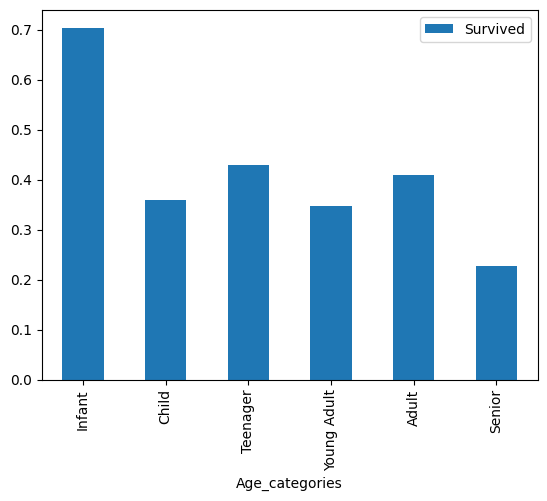

In [ ]:
def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

cut_points = [-1,0,5,12,18,35,60,100]
label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
train = process_age(train,cut_points,label_names)
test = process_age(test,cut_points,label_names)

pivot = train.pivot_table(index="Age_categories",values='Survived')
pivot.plot.bar()

Encoding Categorical Variables
We can use the pandas.get_dummies() function Now, we shall have to encode Sex, Embarked, Pclass and Age_categories. Name and Ticket columns have a lot of categories, hence we shall delete them.

In [ ]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

for column in ["Pclass","Sex","Age_categories",'Embarked']:
    train = create_dummies(train,column)
    test = create_dummies(test,column)

In [ ]:
#Dropping Unnecessary columns

train.drop(['Name','Sex','Ticket','Pclass','Age_categories','Embarked'],inplace=True,axis=1)
test.drop(['Name','Sex','Ticket','Pclass','Age_categories','Embarked'],inplace=True,axis=1)

Logistic Regression Implementation
We will use Logistic Regressionfrom Scikit-Learn model. The only change we will make from the default model settings is to lower the regularization parameter, C, which controls the amount of overfitting (a lower value should decrease overfitting). This will get us slightly better results than the default Logistic Regression.

The .fit() method accepts two arguments: X and y. X must be a two dimensional array (like a dataframe) of the features that we wish to train our model on, and y must be a one-dimensional array (like a series) of our target, or the column we wish to predict.

In [ ]:
lr = LogisticRegression()
columns = ['PassengerId', 'Age', 'Fare','Family',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

lr.fit(train[columns], train["Survived"])

LogisticRegression()

In [ ]:
X = train[columns]
y = train['Survived']

train_X, val_X, train_y, val_y = train_test_split(
    X, y, test_size=0.20,random_state=0)

In [ ]:
lr = LogisticRegression()
lr.fit(train_X, train_y)
predictions = lr.predict(val_X)
accuracy = accuracy_score(val_y, predictions)
print(accuracy)
from sklearn.metrics import classification_report
print(classification_report(val_y,predictions))

0.8044692737430168
              precision    recall  f1-score   support

           0       0.82      0.87      0.85       110
           1       0.77      0.70      0.73        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



In [ ]:
lr = LogisticRegression()
scores = cross_val_score(lr, X, y, cv=10)
scores.sort()
accuracy = scores.mean()

print(scores)
print ('')
print('average accuracy is :', accuracy)

[0.7752809  0.7752809  0.79775281 0.80898876 0.80898876 0.83146067
 0.83146067 0.83146067 0.83333333 0.87640449]

average accuracy is : 0.8170411985018727


In [ ]:
lr = LogisticRegression()
lr.fit(X,y)
predictions_test = lr.predict(test[columns])